# Air Quality Forecast
* Data set location: https://archive.ics.uci.edu/ml/datasets/Air+Quality

* Please use the public data set in the above link to build a model to predict air quality in the upcoming days. You may use your own definition for “Air quality.” It may depend solely on hourly CO concentration for the past 30 days. It may depend on Benzene concentration for the past 7 days. It can also depend on the concentration of a mix of chemicals of your choice.

* **Goal**: Given your definition of air quality, please predict air quality for the next 5 days.

* Points to note
    * We are NOT asking for an accurate prediction
    * We are more interests in your thought process and your methods to tackle the problem
    * Some of the areas we are looking for:
        * “YOUR” definition of air quality and the reasoning behind it
        * The logic for picking the model of your choice
        * How you evaluate the causal relationship between different chemical concentrations as well as the relationship between chemicals and air quality
        * The code used for your analysis/prediction
        * Model validation methods
        * Visualization of your data and result
    * DEFINITE FAIL
        * Trying out textbook model (e.g. SVM, RNN, ARIMA, etc) WITHOUT DETAILED interpretation of results.
    * With limited time, we know it is hard to complete everything perfectly. It is good enough to demonstrate the areas you are most comfortable with. 

In [1]:
# libs
# system
from datetime import datetime
import math
import random

# data prep
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

# model
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

|Name|AirQualityUCI|
|---|---|
|City info|a significantly polluted area|
|Location|Italian city|
|Year|March 2004 – April 2005|
|Number of registers|9357|
|Number of variables|15|

* 0 Date	(DD/MM/YYYY) 
* 1 Time	(HH.MM.SS) 
* 2 True hourly averaged concentration CO in mg/m^3 (reference analyzer) 
* 3 PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)	
* 4 True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer) 
* 5 True hourly averaged Benzene concentration in microg/m^3 (reference analyzer) 
* 6 PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)	
* 7 True hourly averaged NOx concentration in ppb (reference analyzer) 
* 8 PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted) 
* 9 True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)	
* 10 PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)	
* 11 PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted) 
* 12 Temperature in Â°C	
* 13 Relative Humidity (%) 
* 14 Absolute Humidity 

### Exploratory Data Analysis
* 格式
    * Ex. 欄位名稱: 化合物(單位)
---
* 2 **CO(GT)**: CO (mg/m^3)
* 3 **PT08.S1(CO)**: tin oxide, SnO2 氧化錫
* 4 **NMHC(GT)**: Non Metanic HydroCarbons, NMHC(microg/m^3) 非甲烷烴, 除甲烷外，所有碳氫化合物的總稱，為光化學煙霧形成的主要物質，對大氣污染有重要的影響。（甲烷較穩定，故討論碳氫化合物的污染時不包括在內）
* 5 **C6H6(GT)**: Benzene, C6H6(microg/m^3) 苯, 具有高的毒性，也是一种致癌物質
* 6 **PT08.S2(NMHC)**: titania, TiO2 二氧化鈦
* 7 **NOx(GT)**: Nitrogen Oxides, NOx(ppb) 氮氧化物
* 8 **PT08.S3(NOx)**: tungsten oxide 氧化鎢
* 9 **NO2(GT)**: NO2(microg/m^3)
* 10 **PT08.S4(NO2)**: tungsten oxide
* 11 **PT08.S5(O3)**: indium oxide
* 12 **T**: Temperature
* 13 **RH**: Relative Humidity(%)
* 14 **AH**: Absolute Humidity

In [2]:
# due to AirQualityUCI.csv has a lot more missing value, so I choose AirQualityUCI.xlsx instead
xlsx_df = pd.read_excel('AirQualityUCI/AirQualityUCI.xlsx', sep=';')
xlsx_df.head(2)

Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)   C6H6(GT)  \
0 2004-03-10  18:00:00     2.6      1360.00       150  11.881723   
1 2004-03-10  19:00:00     2.0      1292.25       112   9.397165   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0        1045.50    166.0       1056.25    113.0       1692.00      1267.50   
1         954.75    103.0       1173.75     92.0       1558.75       972.25   

      T         RH        AH  
0  13.6  48.875001  0.757754  
1  13.3  47.700000  0.725487

In [3]:
# basic information about this dataframe
xlsx_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
Date             9357 non-null datetime64[ns]
Time             9357 non-null object
CO(GT)           9357 non-null float64
PT08.S1(CO)      9357 non-null float64
NMHC(GT)         9357 non-null int64
C6H6(GT)         9357 non-null float64
PT08.S2(NMHC)    9357 non-null float64
NOx(GT)          9357 non-null float64
PT08.S3(NOx)     9357 non-null float64
NO2(GT)          9357 non-null float64
PT08.S4(NO2)     9357 non-null float64
PT08.S5(O3)      9357 non-null float64
T                9357 non-null float64
RH               9357 non-null float64
AH               9357 non-null float64
dtypes: datetime64[ns](1), float64(12), int64(1), object(1)
memory usage: 1.1+ MB


In [4]:
xlsx_df.isnull().values.any()

False

In [5]:
xlsx_df.describe()

CO(GT)  PT08.S1(CO)     NMHC(GT)     C6H6(GT)  PT08.S2(NMHC)  \
count  9357.000000  9357.000000  9357.000000  9357.000000    9357.000000   
mean    -34.207524  1048.869652  -159.090093     1.865576     894.475963   
std      77.657170   329.817015   139.789093    41.380154     342.315902   
min    -200.000000  -200.000000  -200.000000  -200.000000    -200.000000   
25%       0.600000   921.000000  -200.000000     4.004958     711.000000   
50%       1.500000  1052.500000  -200.000000     7.886653     894.500000   
75%       2.600000  1221.250000  -200.000000    13.636091    1104.750000   
max      11.900000  2039.750000  1189.000000    63.741476    2214.000000   

           NOx(GT)  PT08.S3(NOx)      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
count  9357.000000   9357.000000  9357.000000   9357.000000  9357.000000   
mean    168.604200    794.872333    58.135898   1391.363266   974.951534   
std     257.424561    321.977031   126.931428    467.192382   456.922728   
min    -200.000000   -200.000000  -200.000000   -200.000000  -200.000000   
25%      50.000000    637.000000    53.000000   1184.750000   699.750000   
50%     141.000000    794.250000    96.000000   1445.500000   942.000000   
75%     284.200000    960.250000   133.000000   1662.000000  1255.250000   
max    1479.000000   2682.750000   339.700000   2775.000000  2522.750000   

                 T           RH           AH  
count  9357.000000  9357.000000  9357.000000  
mean      9.776600    39.483611    -6.837604  
std      43.203438    51.215645    38.976670  
min    -200.000000  -200.000000  -200.000000  
25%      10.950000    34.050000     0.692275  
50%      17.200000    48.550000     0.976823  
75%      24.075000    61.875000     1.296223  
max      44.600000    88.725000     2.231036

In [6]:
xlsx_df.shape

(9357, 15)

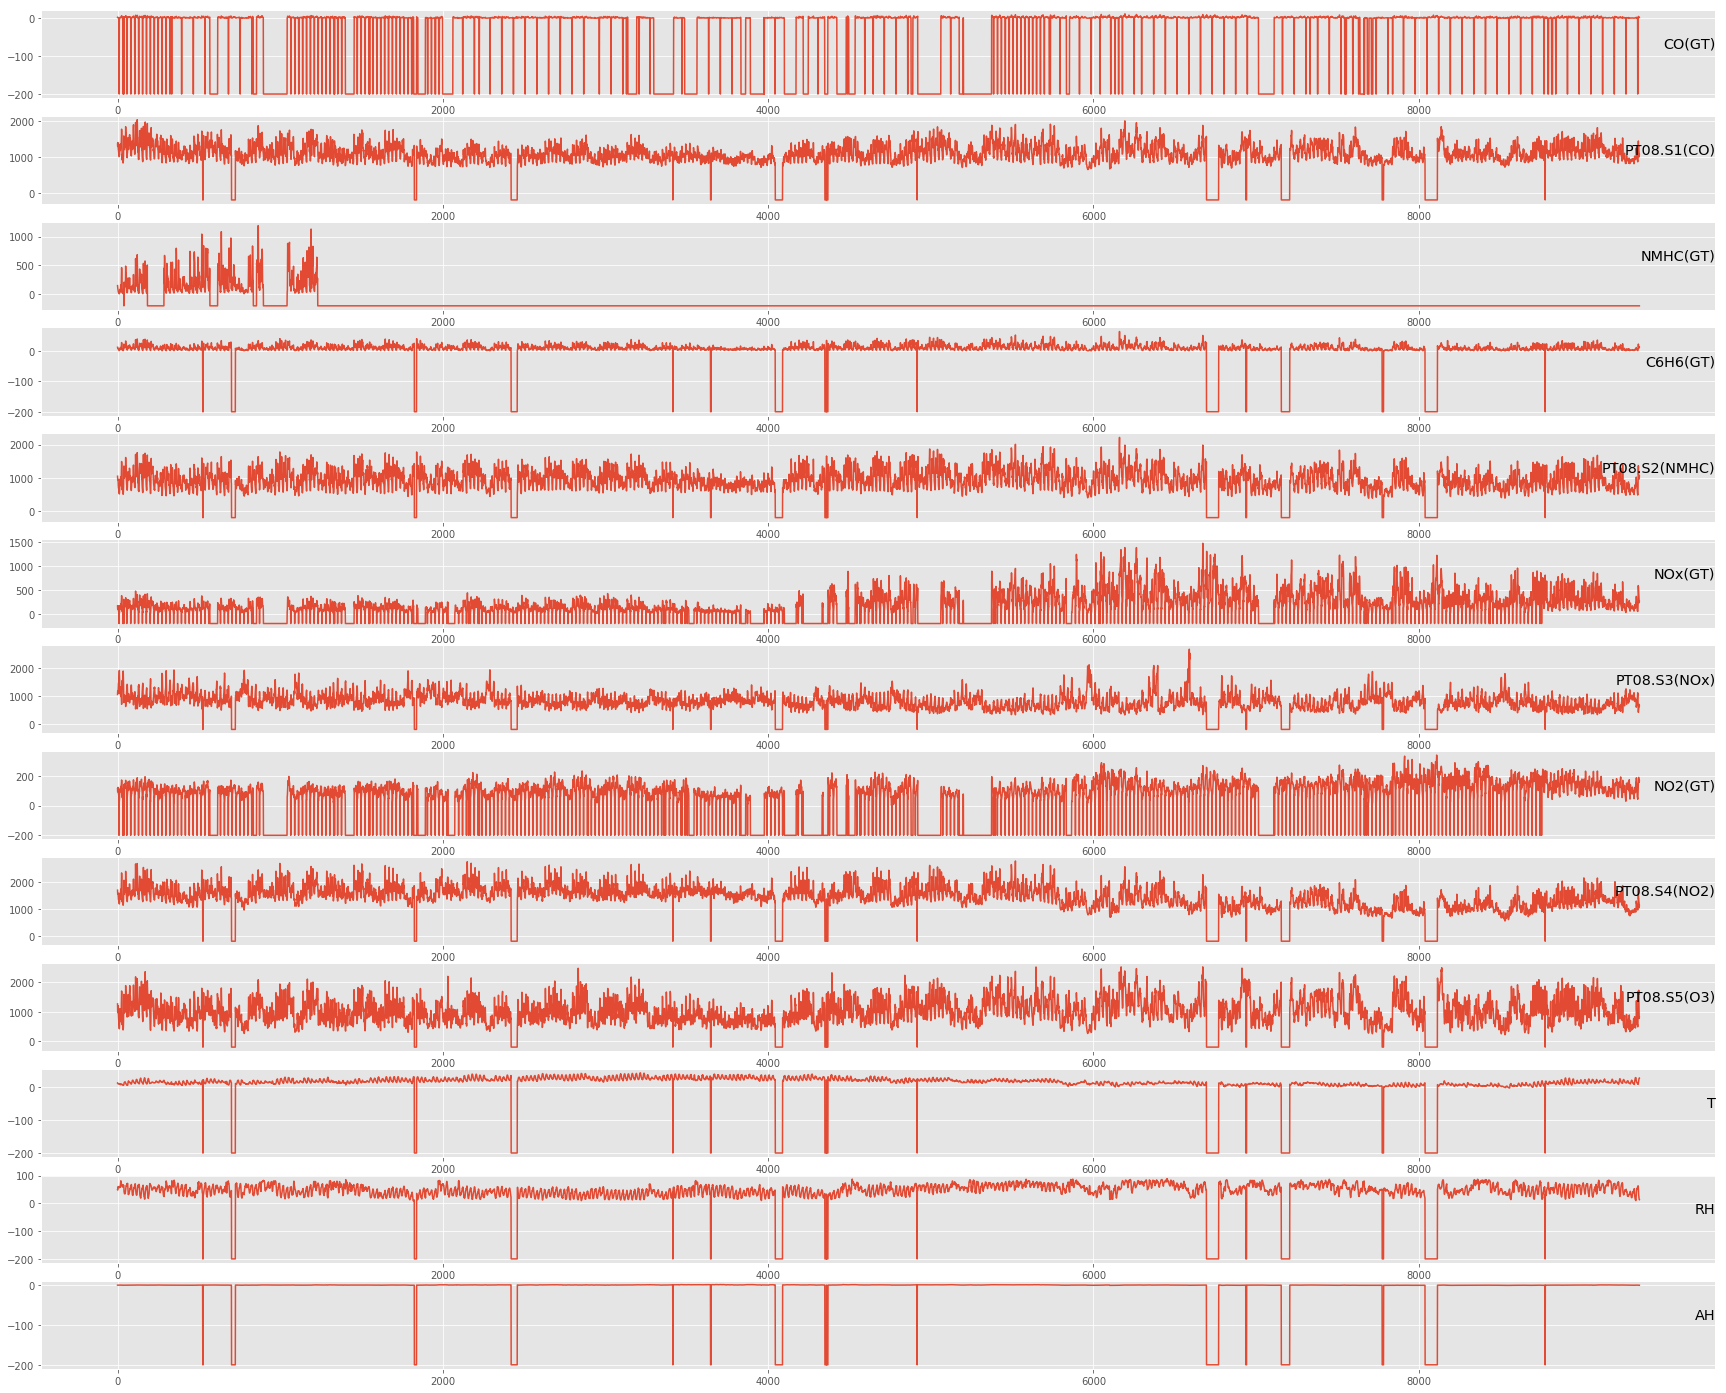

In [7]:
plt.figure(figsize=(30,25))

showList = [x for x in xlsx_df.columns if x not in ['Date', 'Time']]

for i, col in enumerate(showList, start=1):
    plt.subplot(len(showList), 1, i)
    plt.plot(xlsx_df.index, xlsx_df[col].values)
    plt.title(col, y=0.5, loc='right')
plt.show()

### Data preprocessing
* missing values
* outlier
* shift n = 5

#### Missing values
In UCI data set information, it mentioned that missing values are tagged with value `-200`. Replace all missing values with np.NaN

In [8]:
xlsx_df.replace(to_replace= -200, value= np.NaN, inplace= True)

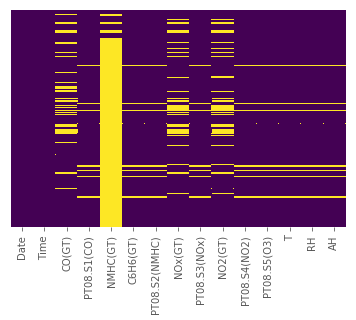

In [9]:
# show missing value in the heatmap
sns.heatmap(xlsx_df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [10]:
xlsx_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
Date             9357 non-null datetime64[ns]
Time             9357 non-null object
CO(GT)           7674 non-null float64
PT08.S1(CO)      8991 non-null float64
NMHC(GT)         914 non-null float64
C6H6(GT)         8991 non-null float64
PT08.S2(NMHC)    8991 non-null float64
NOx(GT)          7718 non-null float64
PT08.S3(NOx)     8991 non-null float64
NO2(GT)          7715 non-null float64
PT08.S4(NO2)     8991 non-null float64
PT08.S5(O3)      8991 non-null float64
T                8991 non-null float64
RH               8991 non-null float64
AH               8991 non-null float64
dtypes: datetime64[ns](1), float64(13), object(1)
memory usage: 1.1+ MB


In the heatmap above, column `NMHC(GT)` missed too much data. Under this circumstance, this feature do not contribute much importance, so we better drop this column.

In [11]:
xlsx_df.drop(['NMHC(GT)'], axis= 1, inplace= True)

In [12]:
# date
xlsx_df['DateTime'] = xlsx_df['Date'].astype(str) + ' ' + xlsx_df['Time'].astype(str)
xlsx_df['DateTime'] = pd.to_datetime(xlsx_df['DateTime'], format='%Y-%m-%d %H:%M:%S')
print(xlsx_df['DateTime'].iloc[:2])

0   2004-03-10 18:00:00
1   2004-03-10 19:00:00
Name: DateTime, dtype: datetime64[ns]


In [13]:
xlsx_df['Date'] = pd.to_datetime(xlsx_df['Date'].astype(str), format='%Y-%m-%d')

In [14]:
# for year trend visualization perpose, this helps
xlsx_df['Year'] = xlsx_df['DateTime'].map(lambda x: x.year)
print(xlsx_df['Year'].iloc[:2])

0    2004
1    2004
Name: Year, dtype: int64


In [15]:
xlsx_df['YearMonth'] = pd.to_datetime(xlsx_df.DateTime).dt.to_period('m')
print(xlsx_df['YearMonth'].iloc[:2])

0    2004-03
1    2004-03
Name: YearMonth, dtype: period[M]


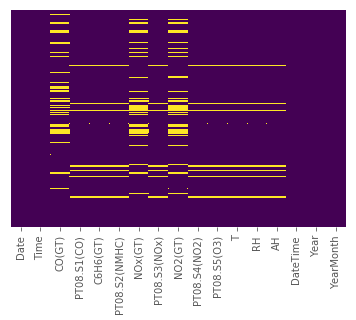

In [16]:
# show missing value again
sns.heatmap(xlsx_df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

#### Fill in NaN value
* Strategy: fill in the missing value with [`median`](http://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.median.html), [`mean`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html), or [`interpolation`](http://pandas.pydata.org/pandas-docs/version/0.16.2/generated/pandas.DataFrame.interpolate.html)
* Other strategy: fill forward, fill backward
* Try every strategy and think **why**

In [17]:
print(xlsx_df.columns)

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH', 'DateTime', 'Year', 'YearMonth'],
      dtype='object')


In [18]:
interpolateList = [x for x in xlsx_df.columns if x not in ['Date', 'Time', 'DateTime', 'Year', 'YearMonth']]

for col in interpolateList:
    xlsx_df[col].interpolate(method='linear', inplace=True)
    
print('Are there any NaN value: ', xlsx_df.isnull().values.any())

Are there any NaN value:  False


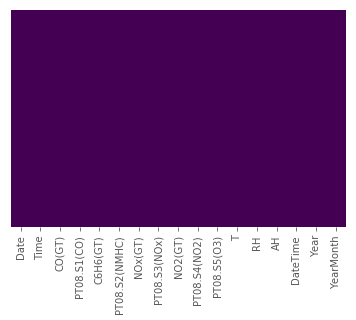

In [19]:
# show missing value again
sns.heatmap(xlsx_df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [20]:
xlsx_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 17 columns):
Date             9357 non-null datetime64[ns]
Time             9357 non-null object
CO(GT)           9357 non-null float64
PT08.S1(CO)      9357 non-null float64
C6H6(GT)         9357 non-null float64
PT08.S2(NMHC)    9357 non-null float64
NOx(GT)          9357 non-null float64
PT08.S3(NOx)     9357 non-null float64
NO2(GT)          9357 non-null float64
PT08.S4(NO2)     9357 non-null float64
PT08.S5(O3)      9357 non-null float64
T                9357 non-null float64
RH               9357 non-null float64
AH               9357 non-null float64
DateTime         9357 non-null datetime64[ns]
Year             9357 non-null int64
YearMonth        9357 non-null period[M]
dtypes: datetime64[ns](2), float64(12), int64(1), object(1), period[M](1)
memory usage: 1.2+ MB


In [21]:
xlsx_df.describe()

CO(GT)  PT08.S1(CO)     C6H6(GT)  PT08.S2(NMHC)      NOx(GT)  \
count  9357.000000  9357.000000  9357.000000    9357.000000  9357.000000   
mean      2.130603  1102.932925    10.178838     942.019562   241.908464   
std       1.431736   218.201561     7.503295     267.864854   204.308147   
min       0.100000   647.250000     0.149048     383.250000     2.000000   
25%       1.100000   937.500000     4.477145     736.000000    96.000000   
50%       1.800000  1066.750000     8.289085     910.333333   180.000000   
75%       2.900000  1238.750000    14.096486    1119.000000   326.000000   
max      11.900000  2039.750000    63.741476    2214.000000  1479.000000   

       PT08.S3(NOx)      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)            T  \
count   9357.000000  9357.000000   9357.000000  9357.000000  9357.000000   
mean     832.634930   109.620033   1453.172887  1032.422456    18.231754   
std      255.708807    46.451523    343.201361   404.442611     8.782368   
min      322.000000     2.000000    551.000000   221.000000    -1.900000   
25%      654.000000    76.000000   1227.000000   733.250000    11.725000   
50%      803.500000   104.827586   1459.500000   970.000000    17.575000   
75%      967.500000   136.400000   1668.250000  1293.000000    24.275001   
max     2682.750000   339.700000   2775.000000  2522.750000    44.600000   

                RH           AH         Year  
count  9357.000000  9357.000000  9357.000000  
mean     49.189157     1.019621  2004.240141  
std      17.194081     0.402203     0.427192  
min       9.175000     0.184679  2004.000000  
25%      35.800000     0.732280  2004.000000  
50%      49.650000     0.989504  2004.000000  
75%      62.250002     1.306671  2004.000000  
max      88.725000     2.231036  2005.000000

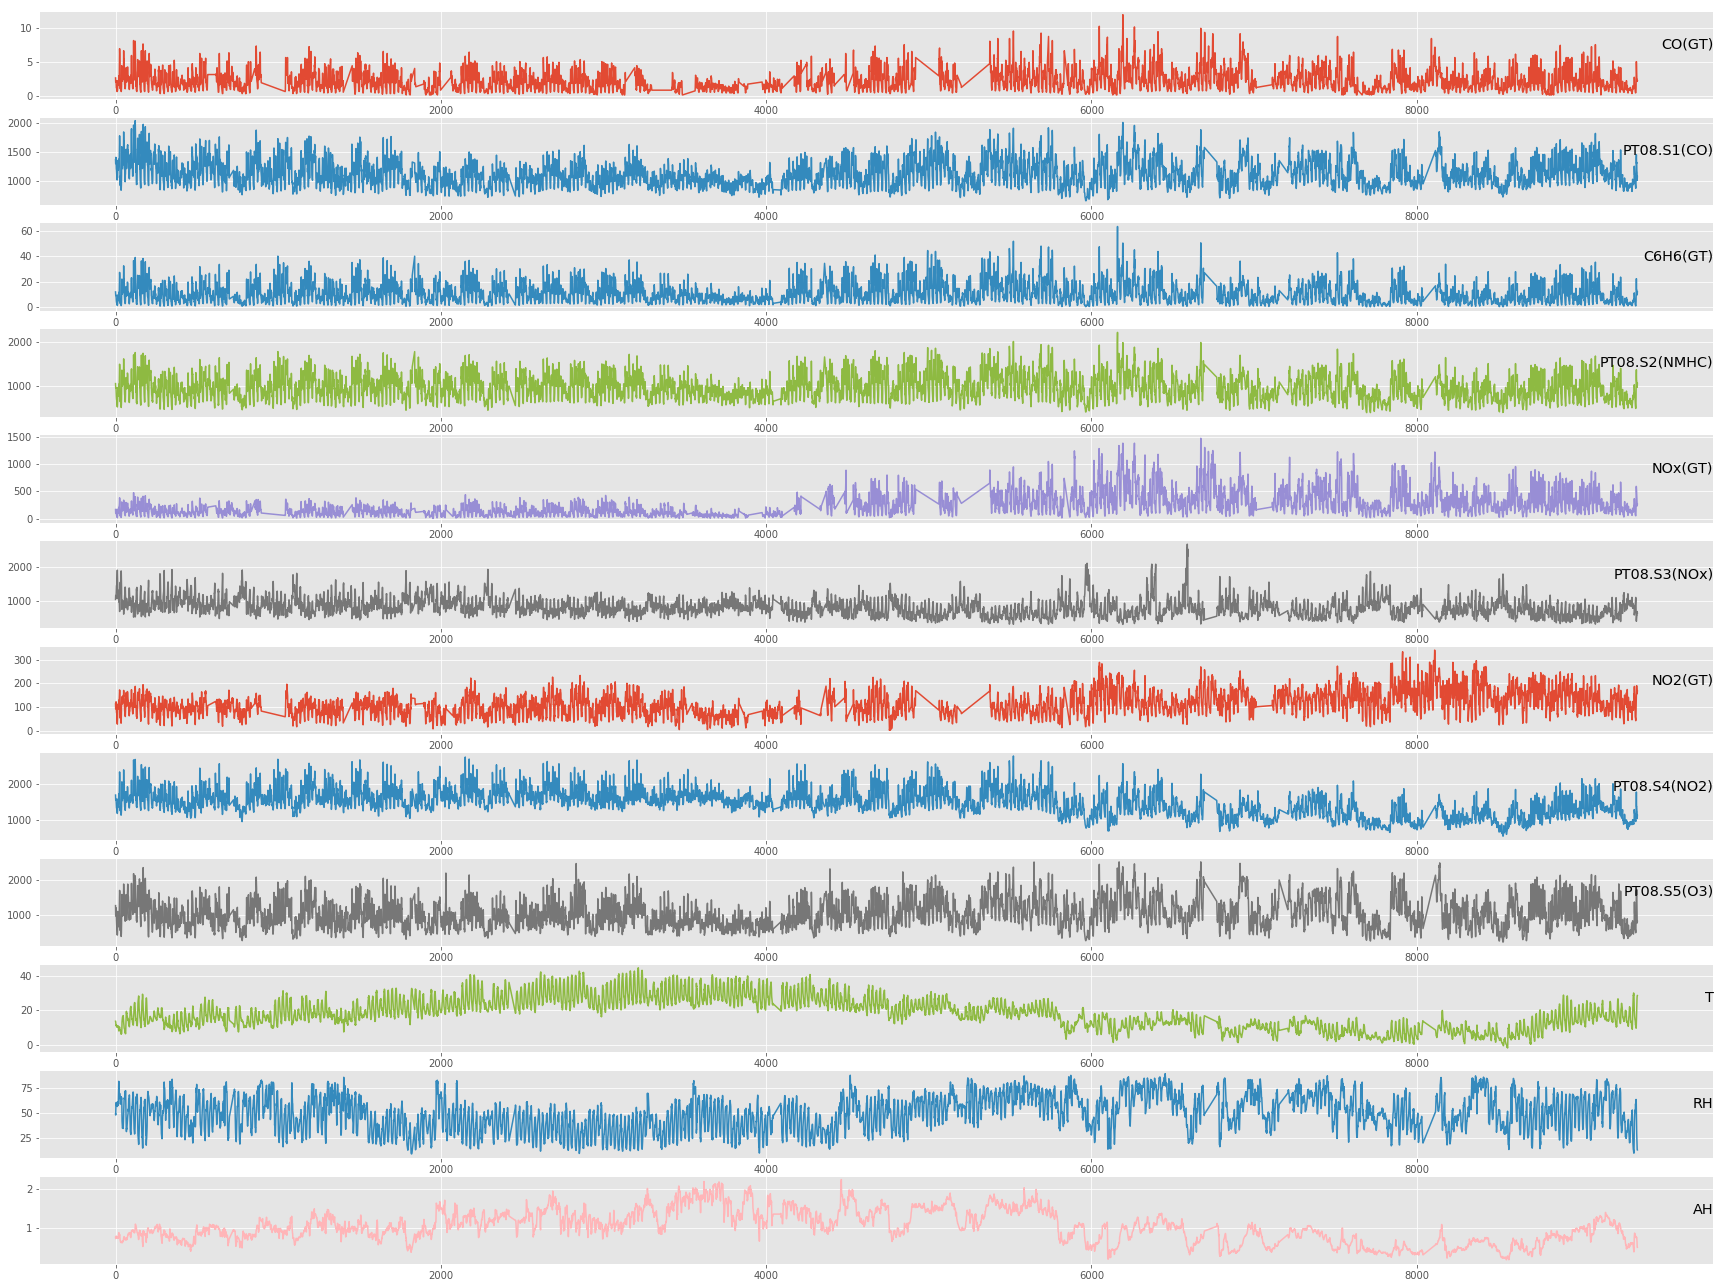

In [22]:
plt.figure(figsize=(30,25))

colorList = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
for i, col in enumerate(interpolateList, start=1):
    plt.subplot(len(showList), 1, i)    
    plt.plot(xlsx_df.index, xlsx_df[col].values, color=random.choice(colorList))
    plt.title(col, y=0.5, loc='right')
plt.show()

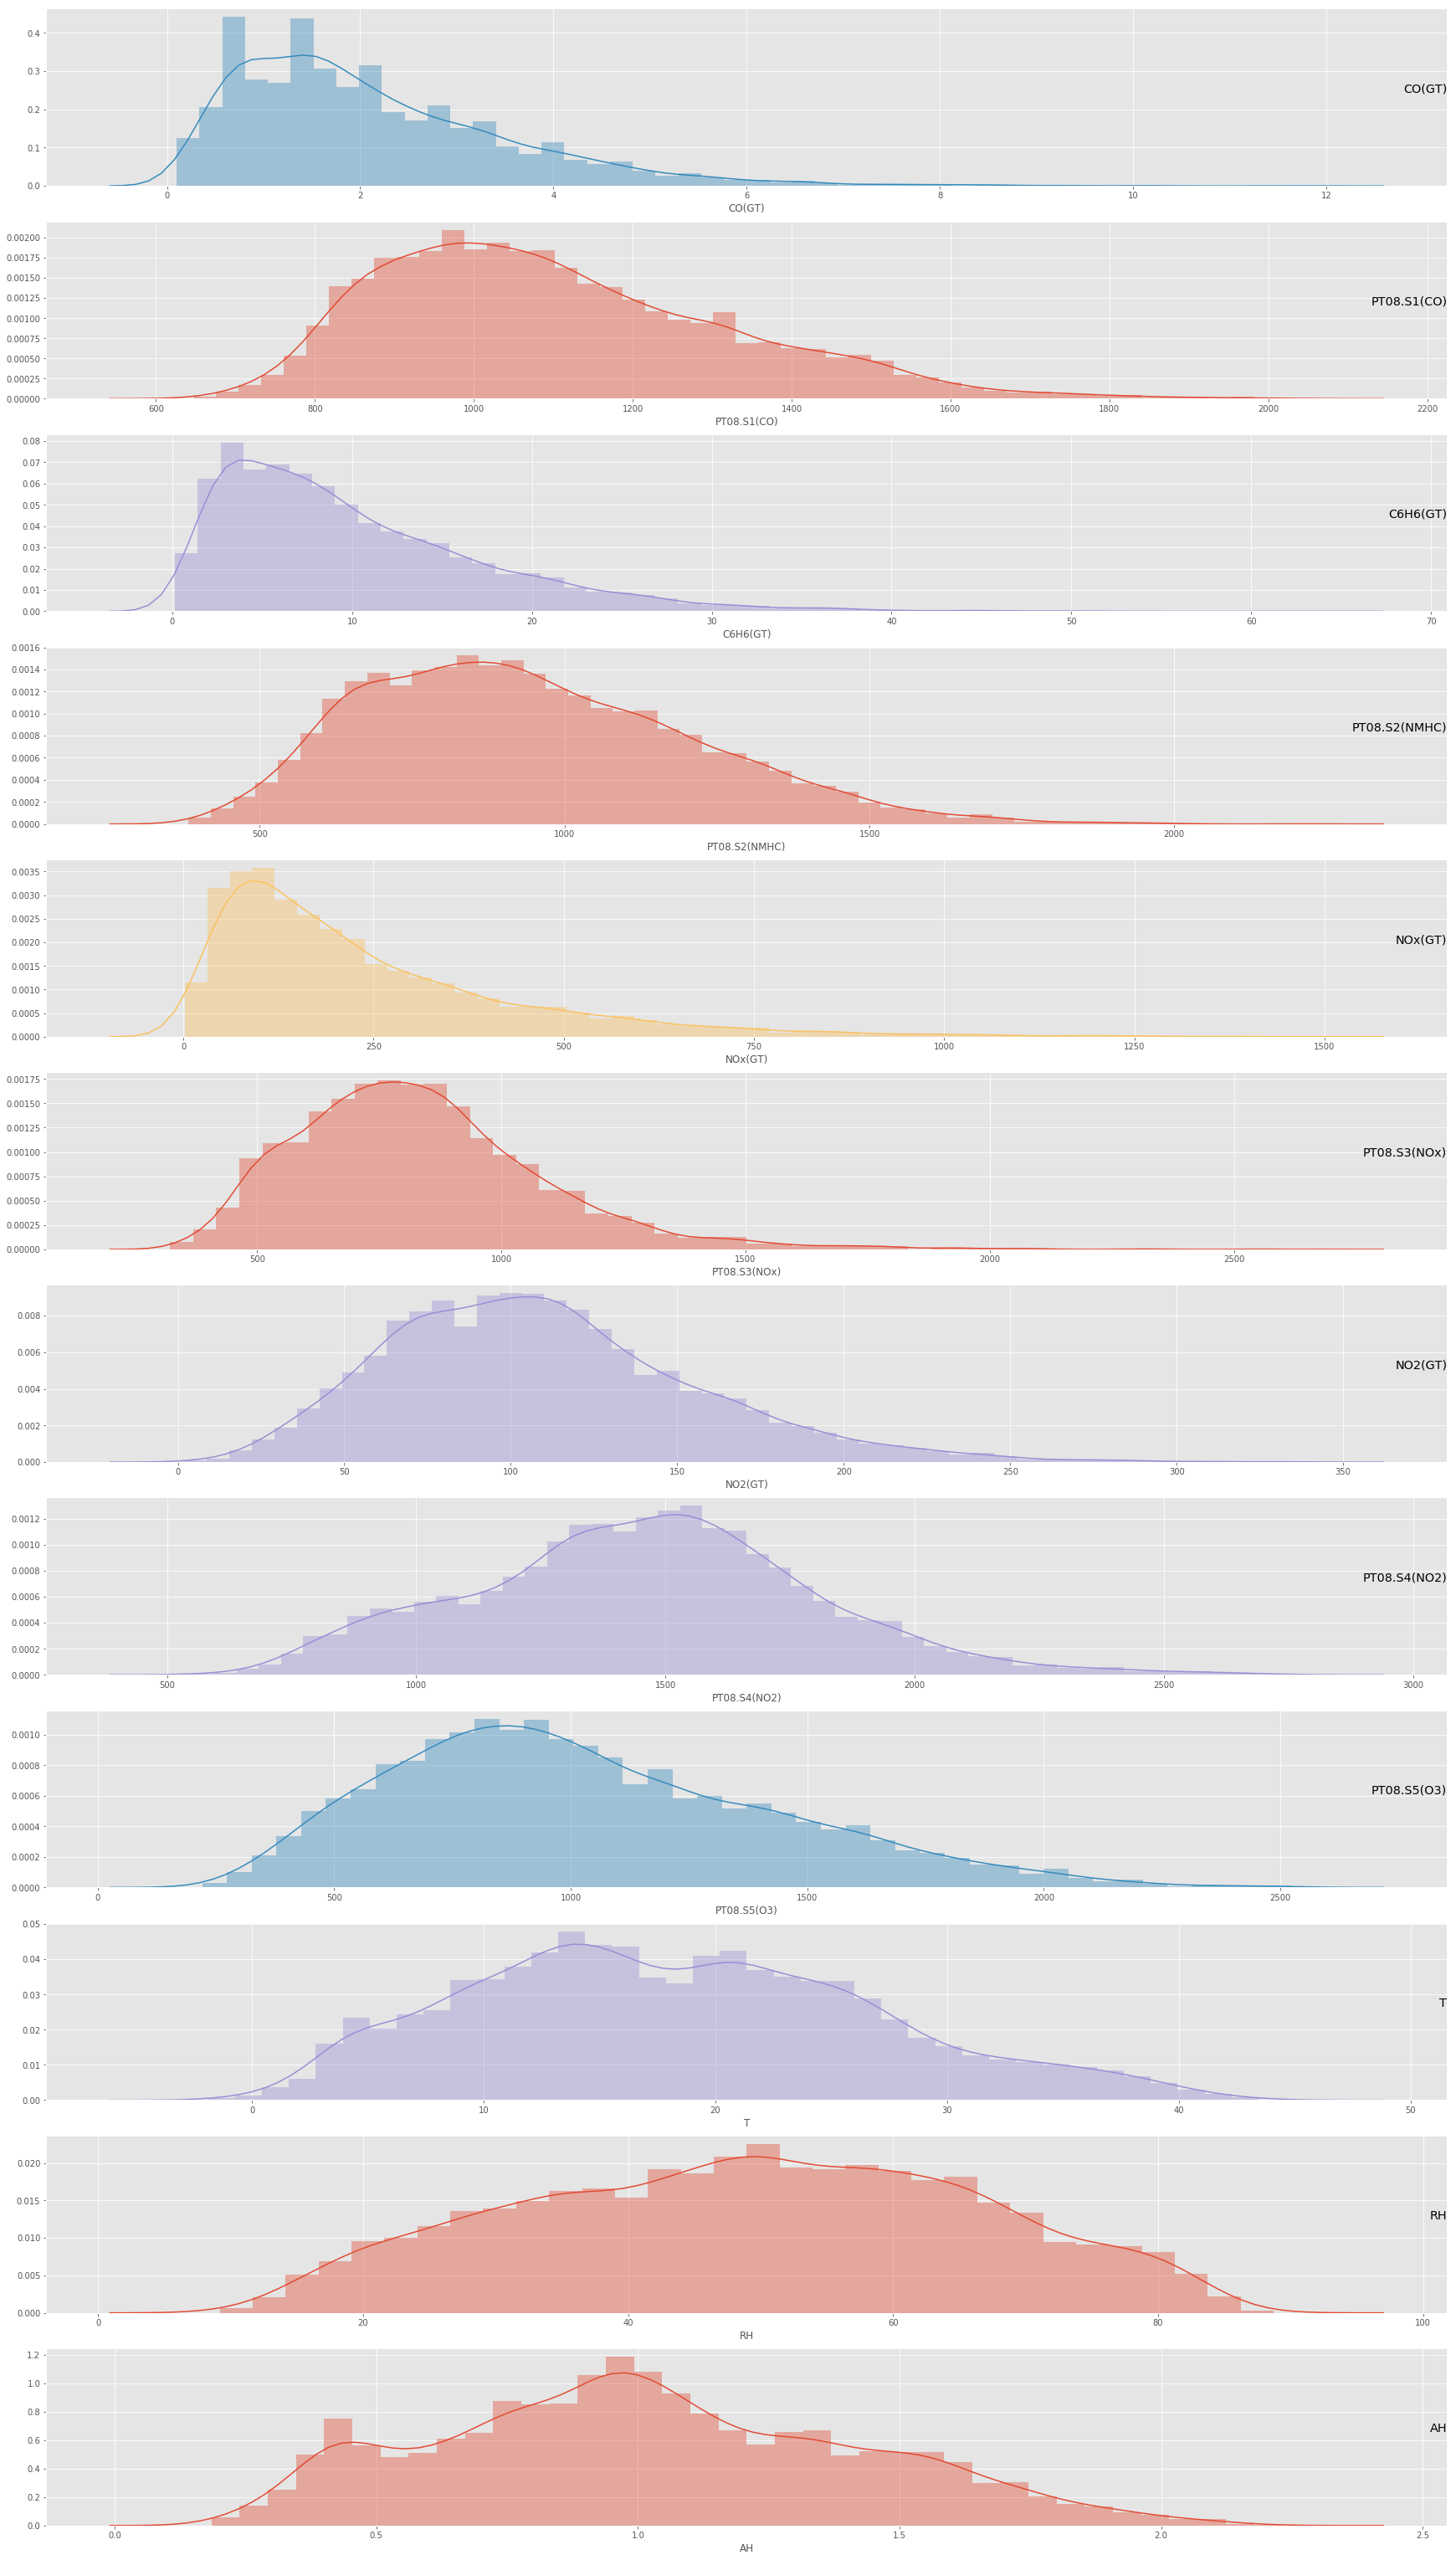

In [23]:
# distribution of each feature
plt.figure(figsize=(30,60))

for i, col in enumerate(interpolateList, start=1):
    plt.subplot(len(showList), 1, i)    
    sns.distplot(xlsx_df[col], color=random.choice(colorList))
    plt.title(col, y=0.5, loc='right')
plt.show()

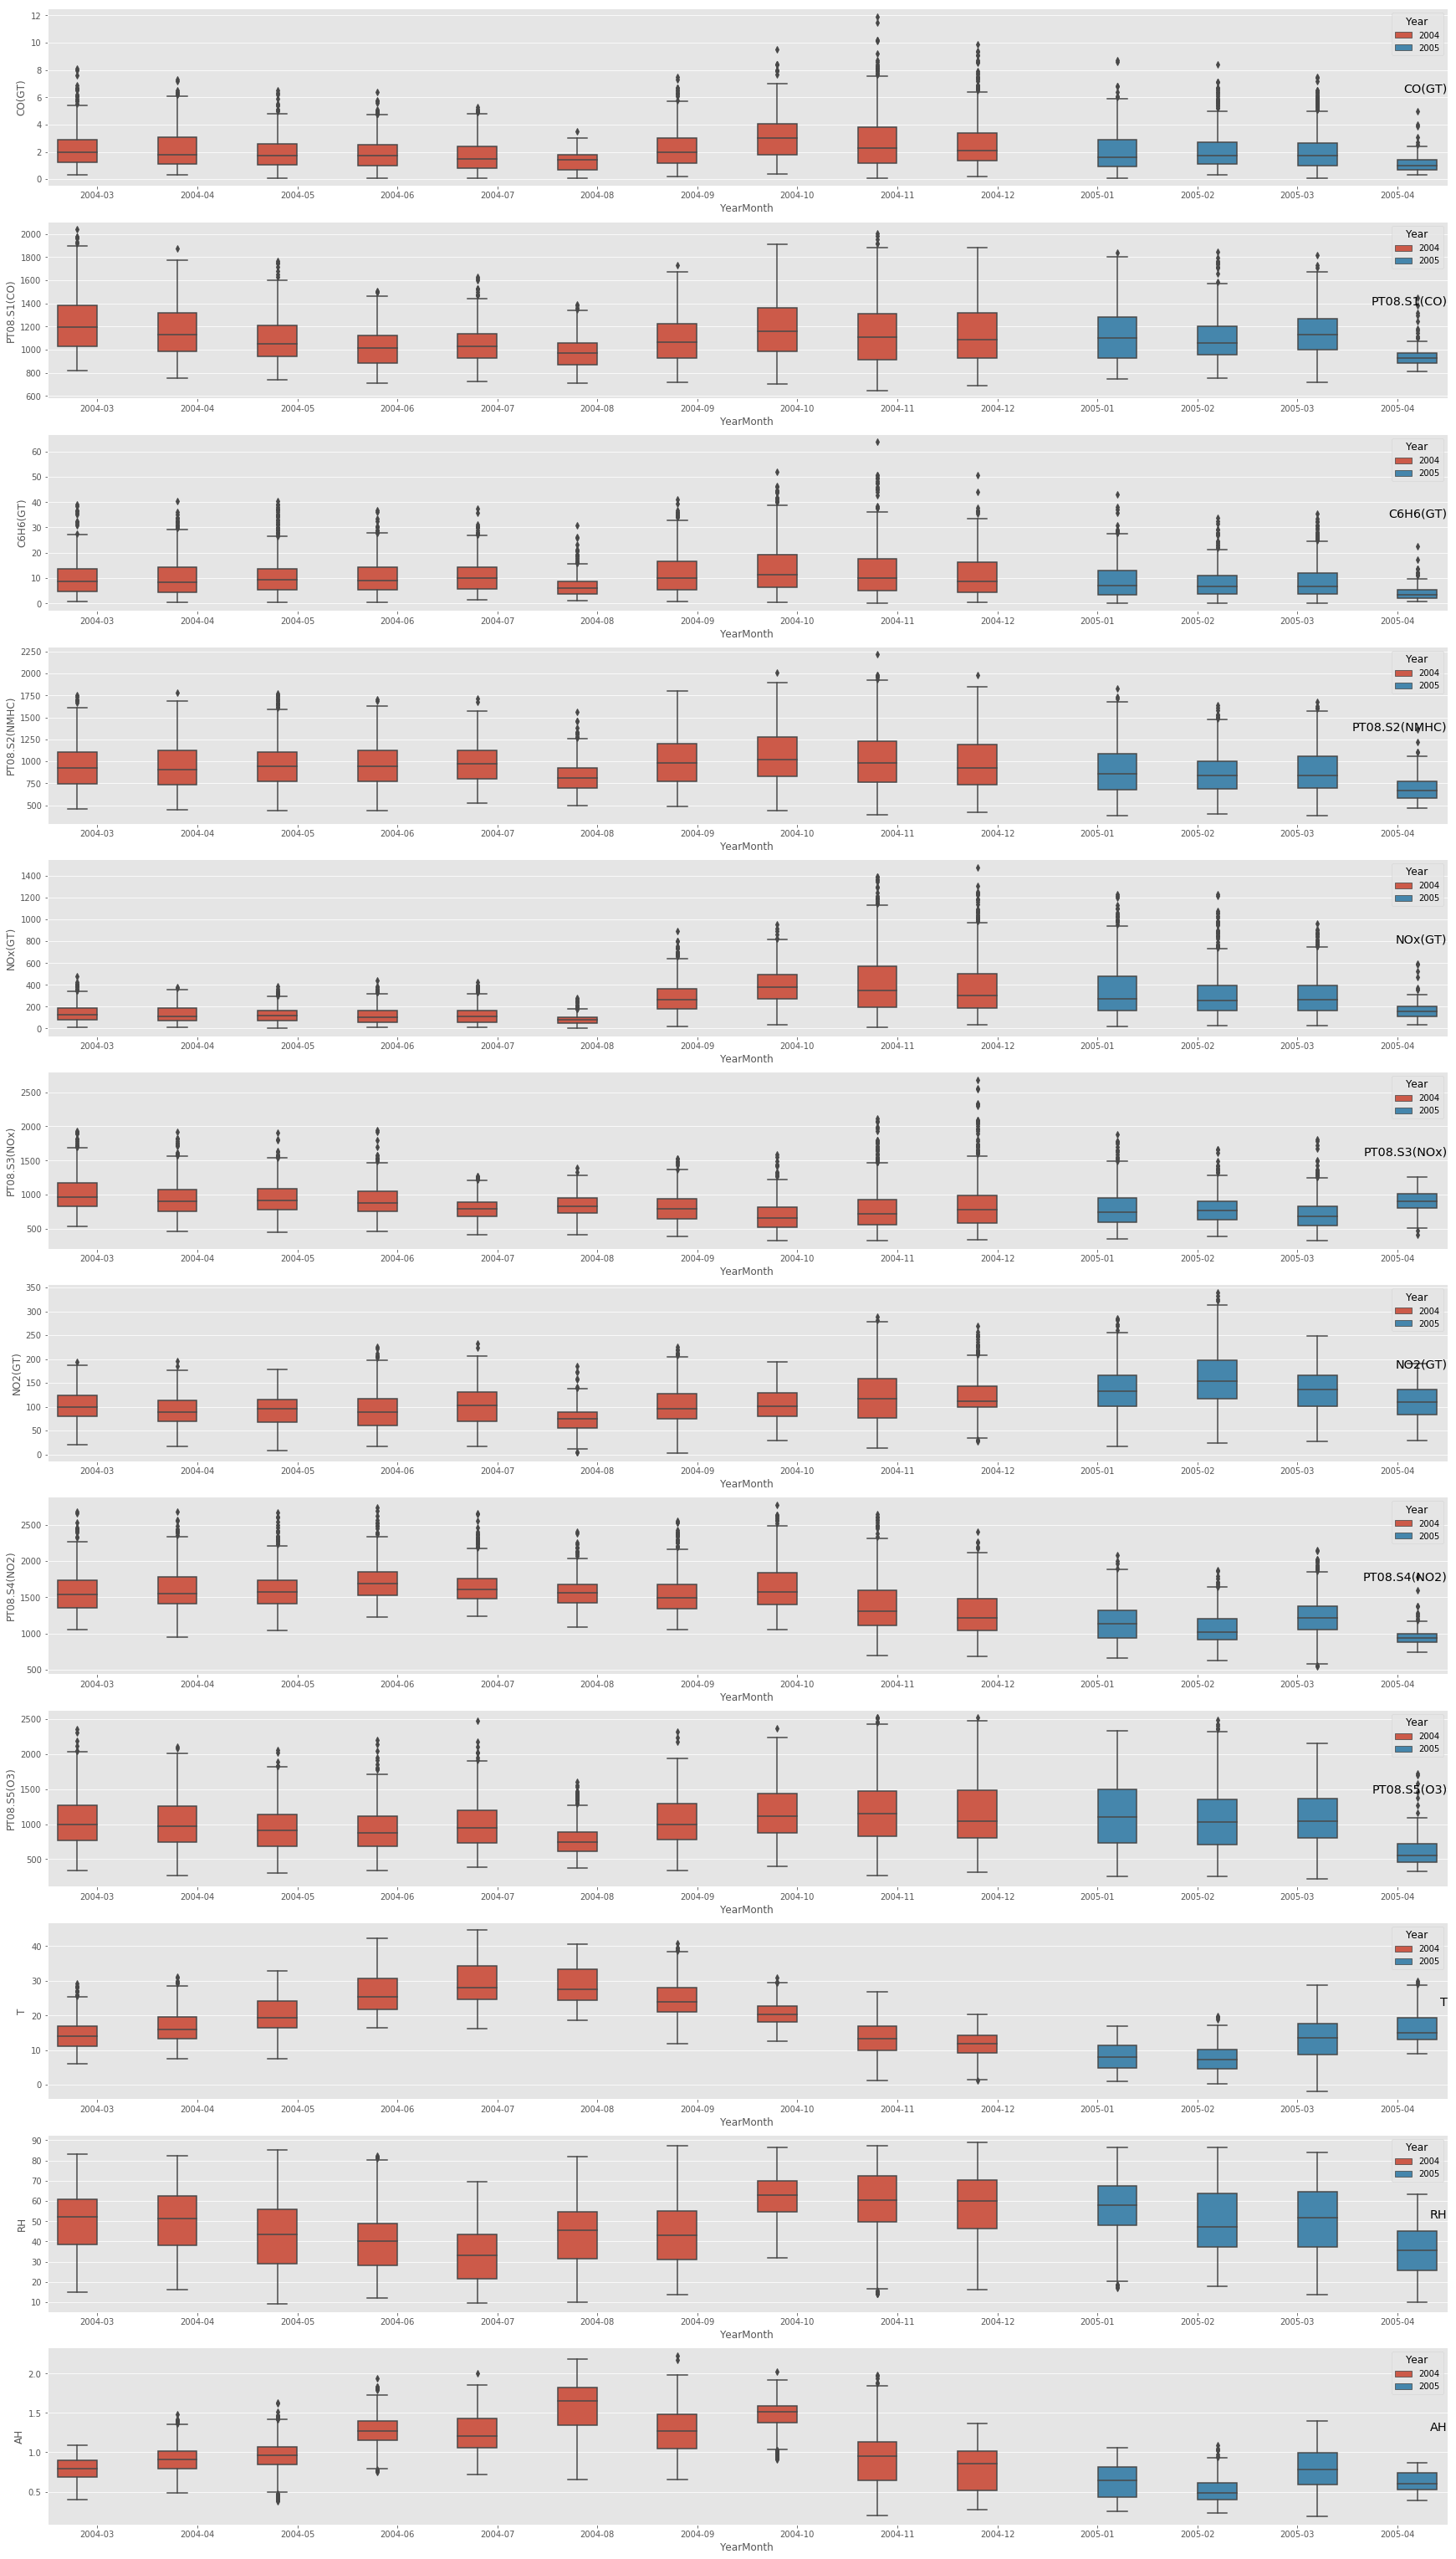

In [24]:
# observe monthly range and deviation.
plt.figure(figsize=(30,60))

for i, col in enumerate(interpolateList, start=1):
    plt.subplot(len(showList), 1, i)    
    sns.boxplot(x='YearMonth', y=col, hue='Year', data=xlsx_df)    
    plt.title(col, y=0.5, loc='right')
plt.show()

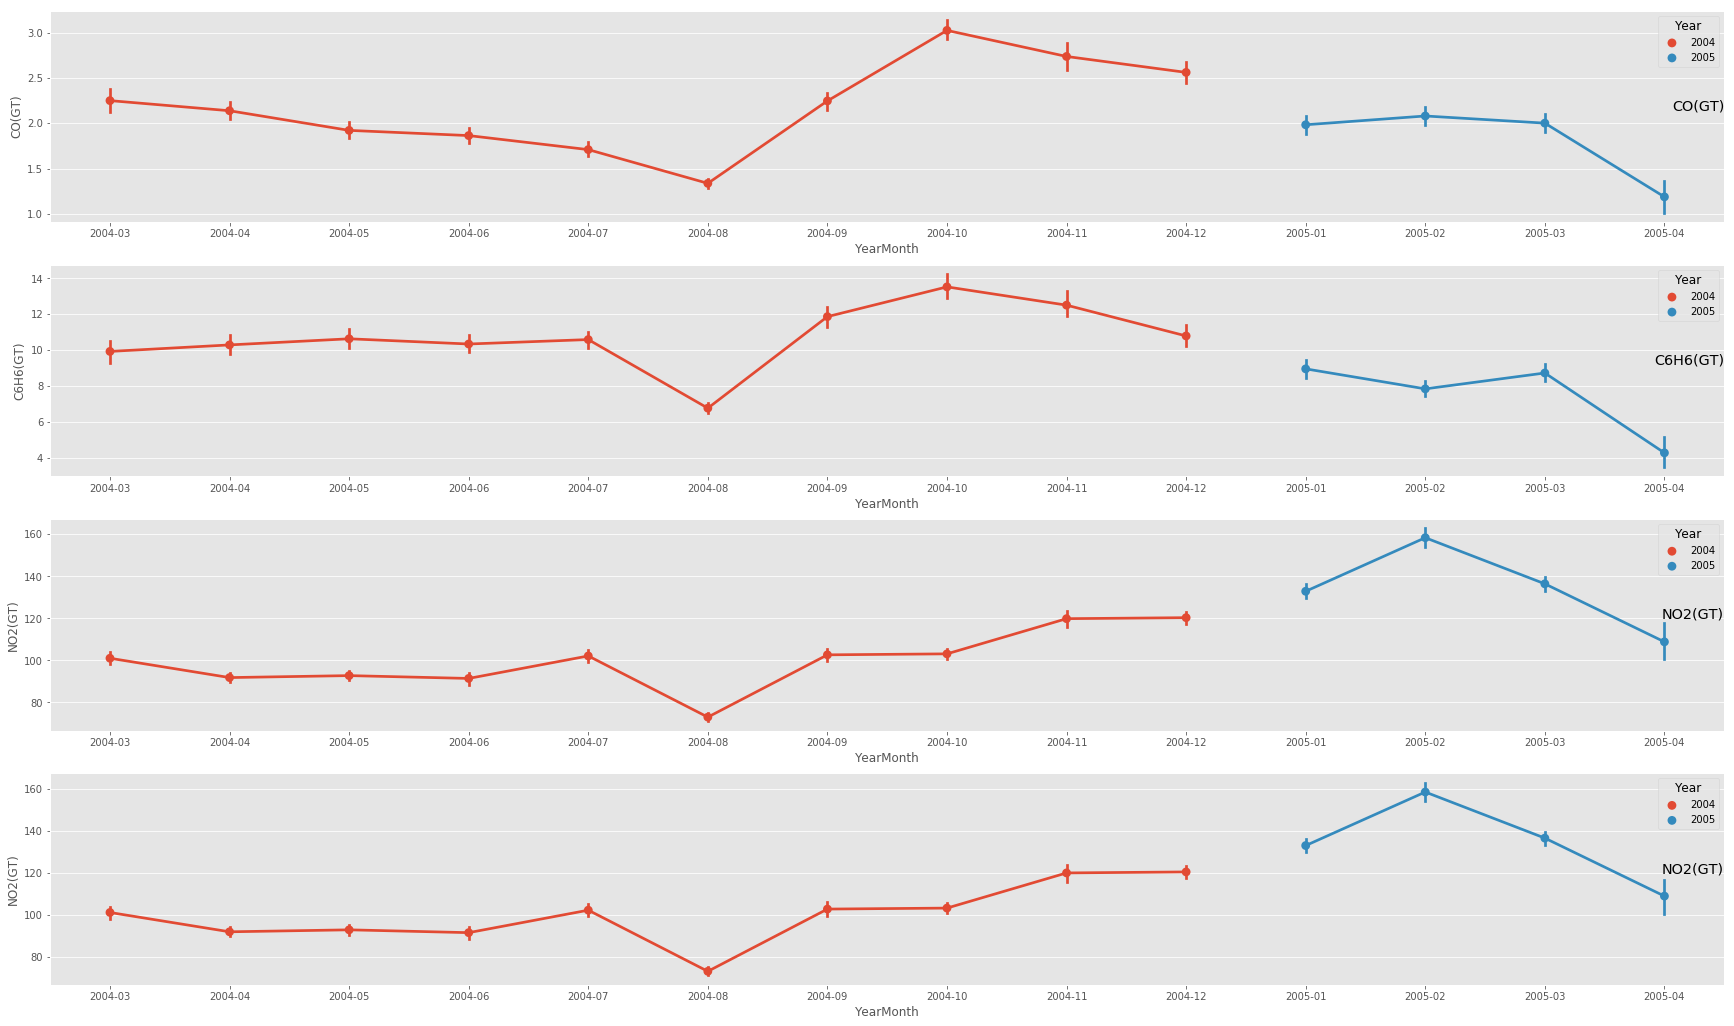

In [25]:
# observe year trend. The concentration shows that all the curves drop until 2004/08 and then rise
# why?
plt.figure(figsize=(30,60))

gasList = ['CO(GT)', 'C6H6(GT)', 'NO2(GT)', 'NO2(GT)']
for i, col in enumerate(gasList, start=1):
    plt.subplot(len(showList), 1, i)    
    sns.pointplot(x='YearMonth', y=col, hue='Year', data=xlsx_df)
    plt.title(col, y=0.5, loc='right')
plt.show()

### Data Engineering
* domain knowledge: chemical
* feature creation: observe every possilbe relationships (ex. correlation) and create useful feature.
* feature selection: select features with low correlation

<Figure size 2880x2880 with 0 Axes>

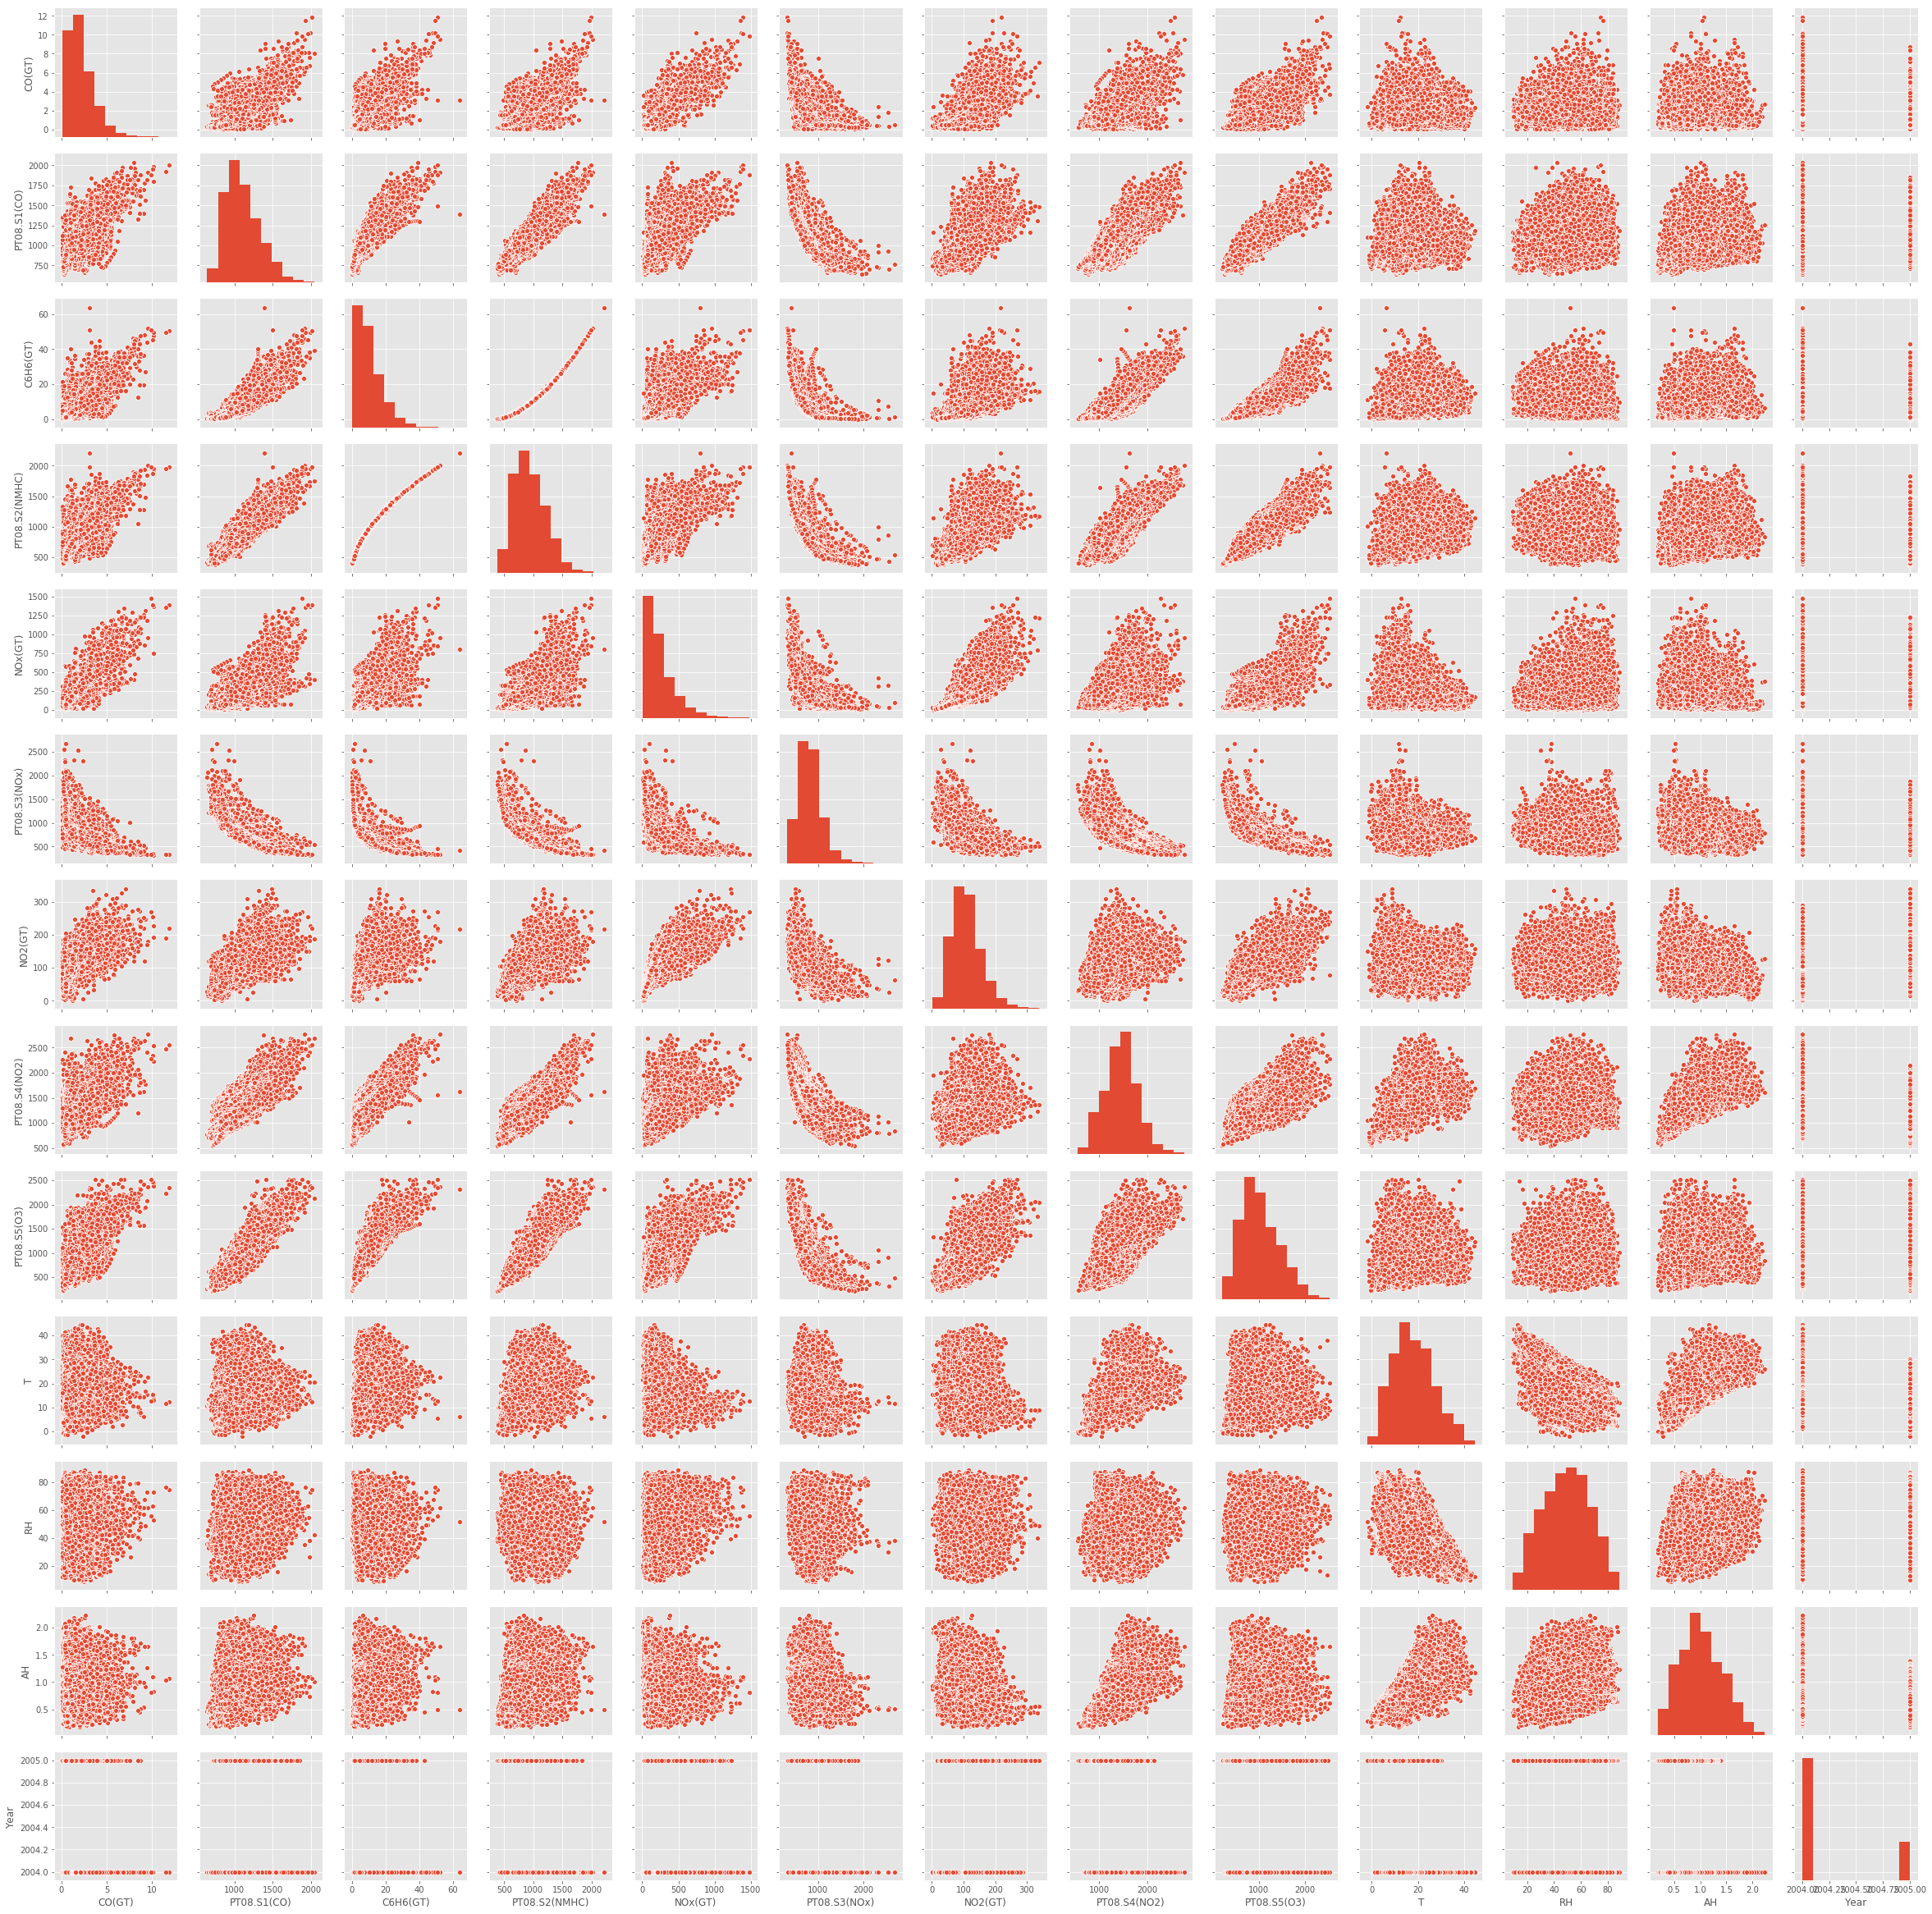

In [26]:
# Basic correlogram
# a scatter plot shows the relationships of two different features.
plt.figure(figsize=(40,40))
sns.pairplot(xlsx_df)
plt.show()

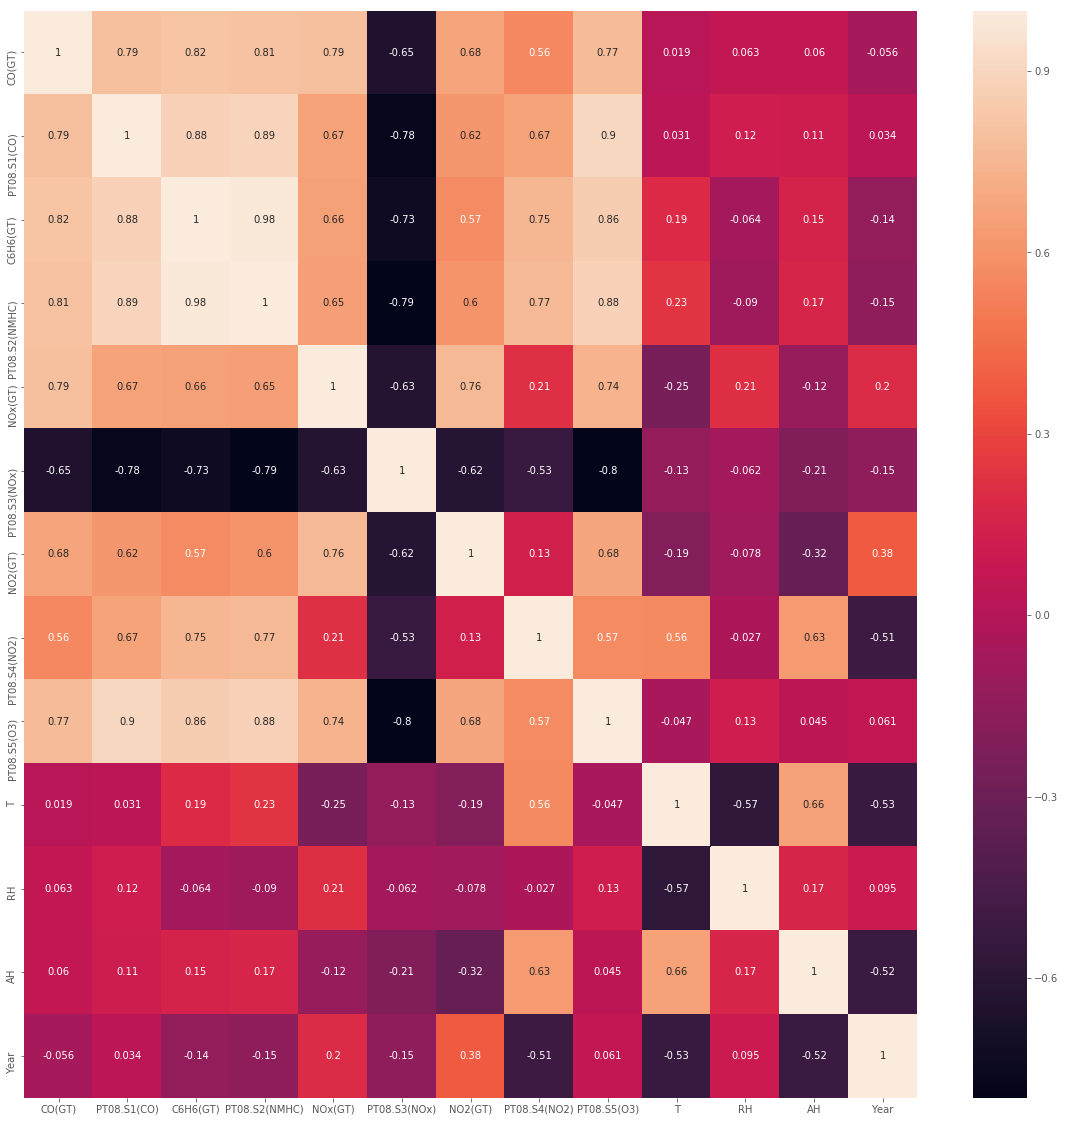

In [27]:
plt.figure(figsize=(20,20))
sns.heatmap(xlsx_df.corr(), annot=True)

In [28]:
print(xlsx_df.corr())

                 CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)   NOx(GT)  \
CO(GT)         1.000000     0.794054  0.816538       0.807102  0.791297   
PT08.S1(CO)    0.794054     1.000000  0.880497       0.892057  0.667124   
C6H6(GT)       0.816538     0.880497  1.000000       0.982287  0.655011   
PT08.S2(NMHC)  0.807102     0.892057  0.982287       1.000000  0.646977   
NOx(GT)        0.791297     0.667124  0.655011       0.646977  1.000000   
PT08.S3(NOx)  -0.647698    -0.777057 -0.730940      -0.793169 -0.626800   
NO2(GT)        0.675975     0.617824  0.570459       0.601871  0.763096   
PT08.S4(NO2)   0.556560     0.667363  0.752283       0.765275  0.214698   
PT08.S5(O3)    0.774820     0.901730  0.858472       0.875145  0.735986   
T              0.018914     0.031311  0.190640       0.230576 -0.246230   
RH             0.062649     0.115478 -0.063588      -0.089766  0.212139   
AH             0.060263     0.112241  0.151742       0.170321 -0.122581   
Year          -0.056073  

In [29]:
print(xlsx_df.corr()['NO2(GT)'].sort_values(ascending=False))

NO2(GT)          1.000000
NOx(GT)          0.763096
PT08.S5(O3)      0.679845
CO(GT)           0.675975
PT08.S1(CO)      0.617824
PT08.S2(NMHC)    0.601871
C6H6(GT)         0.570459
Year             0.377018
PT08.S4(NO2)     0.134468
RH              -0.077893
T               -0.194248
AH              -0.322058
PT08.S3(NOx)    -0.622176
Name: NO2(GT), dtype: float64
